# Node2Vec showcase

This notebook is about showcasing the qualities of the node2vec algorithm aswell as my implementation of it which can be found and pip installed through [this link](https://github.com/eliorc/node2vec).

Check out the related [Medium post](https://medium.com/@eliorcohen/node2vec-embeddings-for-graph-data-32a866340fef).

Data is taken from https://www.kaggle.com/artimous/complete-fifa-2017-player-dataset-global

In [74]:
qtconsole

In [83]:
%matplotlib inline

import warnings
from text_unidecode import unidecode
from collections import deque
warnings.filterwarnings('ignore')


import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from node2vec import Node2Vec

sns.set_style('whitegrid')

### Data loading and pre processing

In [40]:
data = pd.read_csv('C:\my_temp\complete-fifa-2017-player-dataset-global/FullData.csv', usecols=['Name', 'Club', 'Club_Position', 'Rating'])
data

,Name,Club,Club_Position,Rating
0,Cristiano Ronaldo,Real Madrid,LW,94
1,Lionel Messi,FC Barcelona,RW,93
2,Neymar,FC Barcelona,LW,92
3,Luis Suárez,FC Barcelona,ST,92
4,Manuel Neuer,FC Bayern,GK,92
5,De Gea,Manchester Utd,GK,90
6,Robert Lewandowski,FC Bayern,ST,90
7,Gareth Bale,Real Madrid,RW,90
8,Zlatan Ibrahimović,Manchester Utd,ST,90
9,Thibaut Courtois,Chelsea,GK,89


In [82]:
# Load data 
data = pd.read_csv('C:\my_temp\complete-fifa-2017-player-dataset-global/FullData.csv', usecols=['Name', 'Club', 'Club_Position', 'Rating'])

# Lowercase columns for convenience
data.columns = list(map(str.lower, data.columns))

# Reformat strings: lowercase, ' ' -> '_' and é, ô etc. -> e, o
reformat_string = lambda x: unidecode(str.lower(x).replace(' ', '_'))
    
data['name'] = data['name'].apply(reformat_string)
data['club'] = data['club'].apply(reformat_string)

# Lowercase position
data['club_position'] = data['club_position'].str.lower()

# Ignore substitutes and reserves 
#data = data[(data['club_position'] != 'sub') & (data['club_position'] != 'res')]

# Fix lcm rcm -> cm cm
fix_positions = {'rcm' : 'cm', 'lcm': 'cm', 'rcb': 'cb', 'lcb': 'cb', 'ldm': 'cdm', 'rdm': 'cdm'}
data['club_position'] = data['club_position'].apply(lambda x: fix_positions.get(x, x))

# For example sake we will keep only 7 clubs
clubs = {'real_madrid', 'manchester_utd', 
         'manchester_city', 'chelsea', 'juventus', 
         'fc_bayern', 'napoli'}

#data = data[data['club'].isin(clubs)]


# Verify we have 11 player for each team
#assert all(n_players == 11 for n_players in data.groupby('club')['name'].nunique())

data

,name,club,club_position,rating
0,cristiano_ronaldo,real_madrid,lw,94
1,lionel_messi,fc_barcelona,rw,93
2,neymar,fc_barcelona,lw,92
3,luis_suarez,fc_barcelona,st,92
4,manuel_neuer,fc_bayern,gk,92
5,de_gea,manchester_utd,gk,90
6,robert_lewandowski,fc_bayern,st,90
7,gareth_bale,real_madrid,rw,90
8,zlatan_ibrahimovic,manchester_utd,st,90
9,thibaut_courtois,chelsea,gk,89


Here comes the ugly part.
Since we want to put each team of a graph of nodes and edges, I had to hard-code the relationship between the different FIFA 17 formations.

Also since some formations have the same role (CB for example) in different positions connected to different players, I first use a distinct name for each role which after the learning process I will trim so the positions will be the same.

Finally since position are connected differently in each formation we will add a suffix for the graph presentation and we will trim it also before the Word2vec process

Example:

`'cb'` will become `'cb_1_real_madrid'` because it is the first CB, in Real Madrid's formation, and before running the Word2Vec algorithm it will be trimmed to `cb` again

### Formations

In [42]:
FORMATIONS = {'4-3-3_4': {'gk': ['cb_1', 'cb_2'],                           # Real madrid
                          'lb': ['lw', 'cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk'],
                          'cb_2': ['rb', 'cb_1', 'gk'],
                          'rb': ['rw', 'cb_2', 'cm_2'],
                          'cm_1': ['cam', 'lw', 'cb_1', 'lb'],
                          'cm_2': ['cam', 'rw', 'cb_2', 'rb'],
                          'cam': ['cm_1', 'cm_2', 'st'],
                          'lw': ['cm_1', 'lb', 'st'],
                          'rw': ['cm_2', 'rb', 'st'],
                          'st': ['cam', 'lw', 'rw']},
              '5-2-2-1': {'gk': ['cb_1', 'cb_2', 'cb_3'],                   # Chelsea
                          'cb_1': ['gk', 'cb_2', 'lwb'],
                          'cb_2': ['gk', 'cb_1', 'cb_3', 'cm_1', 'cb_2'],
                          'cb_3': ['gk', 'cb_2', 'rwb'],
                          'lwb': ['cb_1', 'cm_1', 'lw'],
                          'cm_1': ['lwb', 'cb_2', 'cm_2', 'lw', 'st'],
                          'cm_2': ['rwb', 'cb_2', 'cm_1', 'rw', 'st'],
                          'rwb': ['cb_3', 'cm_2', 'rw'],
                          'lw': ['lwb', 'cm_1', 'st'],
                          'st': ['lw', 'cm_1', 'cm_2', 'rw'],
                          'rw': ['st', 'rwb', 'cm_2']},
              '4-3-3_2': {'gk': ['cb_1', 'cb_2'],                           # Man UTD / CITY
                          'lb': ['cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk', 'cdm'],
                          'cb_2': ['rb', 'cb_1', 'gk', 'cdm'],
                          'rb': ['cb_2', 'cm_2'],
                          'cm_1': ['cdm', 'lw', 'lb', 'st'],
                          'cm_2': ['cdm', 'rw', 'st', 'rb'],
                          'cdm': ['cm_1', 'cm_2', 'cb_1', 'cb_2'],
                          'lw': ['cm_1', 'st'],
                          'rw': ['cm_2', 'st'],
                          'st': ['cm_1', 'cm_2', 'lw', 'rw']},              # Juventus, Bayern
              '4-2-3-1_2': {'gk': ['cb_1', 'cb_2'],
                            'lb': ['lm', 'cdm_1', 'cb_1'],
                            'cb_1': ['lb', 'cdm_1', 'gk', 'cb_2'],
                            'cb_2': ['rb', 'cdm_2', 'gk', 'cb_1'],
                            'rb': ['cb_2', 'rm', 'cdm_2'],
                            'lm': ['lb', 'cdm_1', 'st', 'cam'],
                            'rm': ['rb', 'cdm_2', 'st', 'cam'],
                            'cdm_1': ['lm', 'cb_1', 'rb', 'cam'],
                            'cdm_2': ['rm', 'cb_2', 'lb', 'cam'],
                            'cam': ['cdm_1', 'cdm_2', 'rm', 'lm', 'st'],
                            'st': ['lm', 'rm', 'cam']},
              '4-3-3': {'gk': ['cb_1', 'cb_2'],                             # Napoli
                        'lb': ['cb_1', 'cm_1'],
                        'cb_1': ['lb', 'cb_2', 'gk', 'cm_2'],
                        'cb_2': ['rb', 'cb_1', 'gk', 'cm_2'],
                        'rb': ['cb_2', 'cm_3'],
                        'cm_1': ['cm_2', 'lw', 'lb'],
                        'cm_3': ['cm_2', 'rw', 'rb'],
                        'cm_2': ['cm_1', 'cm_3', 'st', 'cb_1', 'cb_2'],
                        'lw': ['cm_1', 'st'],
                        'rw': ['cm_3', 'st'],
                        'st': ['cm_2', 'lw', 'rw']}}


### Creating the graphs for each team

In [84]:
add_club_suffix = lambda x, c: x + '_{}'.format(c)

graph = nx.Graph()
formatted_positions = set()

def club2graph(club_name, formation, graph):
    club_data = data[data['club'] == club_name]
    
    club_formation = FORMATIONS[formation]
    
    club_positions = dict()
    
    # Assign positions to players
    available_positions = deque(club_formation)
    available_players = set(zip(club_data['name'], club_data['club_position']))
    
    roster = dict()  # Here we will store the assigned players and positions
    
    while available_positions:
        position = available_positions.pop()
        name, pos = [(name, position) for name, p in available_players if position.startswith(p)][0]        
        
        roster[name] = pos
        
        available_players.remove((name, pos.split('_')[0]))
        
    reverse_roster = {v: k for k, v in roster.items()}
        
    # Build the graph
    for name, position in roster.items():
        # Connect to team name
        graph.add_edge(name, club_name)
        
        # Inter team connections
        for teammate_position in club_formation[position]:
            # Connect positions
            graph.add_edge(add_club_suffix(position, club_name),
                           add_club_suffix(teammate_position, club_name))
            
            # Connect player to teammate positions
            graph.add_edge(name,
                           add_club_suffix(teammate_position, club_name))
            
            # Connect player to teammates
            graph.add_edge(name, reverse_roster[teammate_position])
            
            # Save for later trimming
            formatted_positions.add(add_club_suffix(position, club_name))
            formatted_positions.add(add_club_suffix(teammate_position, club_name))
            
    return graph

In [85]:
teams = [('real_madrid', '4-3-3_4'), 
         ('chelsea', '5-2-2-1'),
         ('manchester_utd', '4-3-3_2'),
         ('manchester_city', '4-3-3_2'),
         ('juventus', '4-2-3-1_2'),
         ('fc_bayern', '4-2-3-1_2'),
         ('napoli', '4-3-3')]

In [86]:
graph = club2graph('real_madrid', '4-3-3_4', graph)

for team, formation in teams:
    graph = club2graph(team, formation, graph)

### Node2Vec algorithm

In [87]:
node2vec = Node2Vec(graph, dimensions=20, walk_length=16, num_walks=100, workers=2,p=1,q=2)

Computing transition probabilities: 100%|██| 161/161 [00:00<00:00, 1518.78it/s]


In [20]:
fix_formatted_positions = lambda x: x.split('_')[0] if x in formatted_positions else x
reformatted_walks = [list(map(fix_formatted_positions, walk)) for walk in node2vec.walks]
node2vec.walks = reformatted_walks

In [21]:
model = node2vec.fit(window=10, min_count=1)

#### Most similar nodes

In [58]:
for node, _ in model.most_similar('rw'):
    # Show only players
    if len(node) > 3:
        print(node)

jose_callejon
gareth_bale
pedro
raheem_sterling
henrikh_mkhitaryan
amadou_diawara


In [23]:
for node, _ in model.most_similar('gk'):
    # Show only players
    if len(node) > 3:
        print(node)

gary_cahill
manuel_neuer
gianluigi_buffon
keylor_navas
thibaut_courtois
david_luiz
willy_caballero


In [59]:
for node, lol in model.most_similar('real_madrid'):
    print(node, lol)

luka_modric 0.910836935043335
james_rodriguez 0.9043644070625305
marcelo 0.8963054418563843
sergio_ramos 0.8914610743522644
cristiano_ronaldo 0.8847668170928955
toni_kroos 0.8668732643127441
keylor_navas 0.8583385944366455
carvajal 0.8538511991500854
pepe 0.846101701259613
gareth_bale 0.8383463621139526


In [88]:
for node, sc in model.most_similar('manuel_neuer', topn=40):
    print(node,sc)

mats_hummels 0.9689944982528687
javi_martinez 0.9452769756317139
fc_bayern 0.8926329016685486
david_alaba 0.8871869444847107
philipp_lahm 0.8723044395446777
arturo_vidal 0.8578442335128784
thiago 0.8328909277915955
thomas_muller 0.7226499319076538
arjen_robben 0.715905487537384
douglas_costa 0.7020912766456604
robert_lewandowski 0.6503046751022339
thibaut_courtois 0.4826388359069824
gary_cahill 0.4743909537792206
jose_reina 0.4105214476585388
david_luiz 0.38842570781707764
azpilicueta 0.37375408411026
willy_caballero 0.37298741936683655
raul_albiol 0.3672133684158325
nicolas_otamendi 0.3635648787021637
kalidou_koulibaly 0.3551301658153534
de_gea 0.3476528525352478
eric_bailly 0.342024564743042
chris_smalling 0.31430917978286743
lm 0.3069261312484741
john_stones 0.2935851216316223
keylor_navas 0.2919124662876129
pepe 0.27853983640670776
gk 0.26377907395362854
elseid_hysaj 0.2617320120334625
victor_moses 0.24789951741695404
faouzi_ghoulam 0.2385786771774292
daley_blind 0.2309945374727249

In [73]:
for node, sc in model.most_similar('manuel_neuer', topn=40):
    print(node,sc)

mats_hummels 0.9689944982528687
javi_martinez 0.9452769756317139
fc_bayern 0.8926329016685486
david_alaba 0.8871869444847107
philipp_lahm 0.8723044395446777
arturo_vidal 0.8578442335128784
thiago 0.8328909277915955
thomas_muller 0.7226499319076538
arjen_robben 0.715905487537384
douglas_costa 0.7020912766456604
robert_lewandowski 0.6503046751022339
thibaut_courtois 0.4826388359069824
gary_cahill 0.4743909537792206
jose_reina 0.4105214476585388
david_luiz 0.38842570781707764
azpilicueta 0.37375408411026
willy_caballero 0.37298741936683655
raul_albiol 0.3672133684158325
nicolas_otamendi 0.3635648787021637
kalidou_koulibaly 0.3551301658153534
de_gea 0.3476528525352478
eric_bailly 0.342024564743042
chris_smalling 0.31430917978286743
lm 0.3069261312484741
john_stones 0.2935851216316223
keylor_navas 0.2919124662876129
pepe 0.27853983640670776
gk 0.26377907395362854
elseid_hysaj 0.2617320120334625
victor_moses 0.24789951741695404
faouzi_ghoulam 0.2385786771774292
daley_blind 0.2309945374727249

#### Visualization

In [28]:
player_nodes = [x for x in model.wv.vocab if len(x) > 3 and x not in clubs]
embeddings = np.array([model.wv[x] for x in player_nodes])

In [29]:
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)

In [30]:
# Assign colors to players
team_colors = {
    'real_madrid': 'lightblue',
    'chelsea': 'b',
    'manchester_utd': 'r',
    'manchester_city': 'teal',
    'juventus': 'gainsboro',
    'napoli': 'deepskyblue',
    'fc_bayern': 'tomato' 
}

data['color'] = data['club'].apply(lambda x: team_colors[x])
player_colors = dict(zip(data['name'], data['color']))
colors = [player_colors[x] for x in player_nodes]

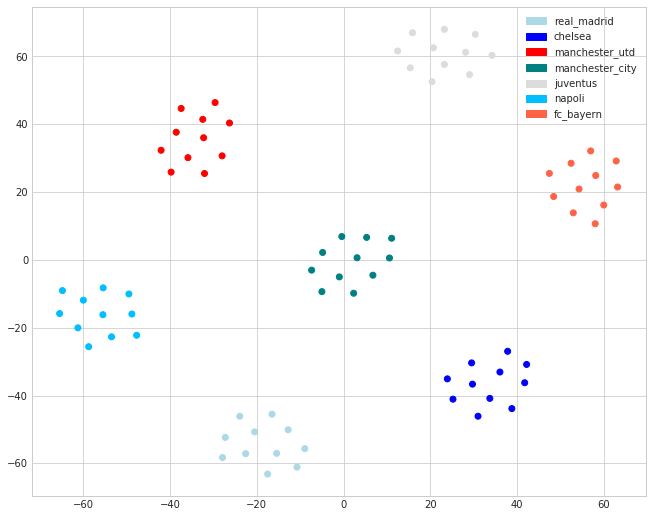

In [54]:
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)

# Create team patches for legend
team_patches = [mpatches.Patch(color=color, label=team) for team, color in team_colors.items()]
ax.legend(handles=team_patches);